# Examen Final - Temas Avanzados en Computación
##### Integrantes:
* 20110324        Zorrilla Maguiña, Louis Javier
* 20154373	      Ormeño Meza, Ruben Aaron
* 20160236	      Ulloa Coronado, Adrian Eduardo

## 0. Carga de librerías empleadas

In [1]:
from PIL import Image
from tensorflow.python.ops import math_ops
from imgaug import augmenters as iaa
import math
import numpy as np
import statistics
import PIL
import glob
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D

import imgaug as ia
from random import randrange
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

## 1. Organización de datos

### Limpiar datos previos

In [2]:
!sudo rm -rf /home/ubuntu/tac/Mi3_Aligned
!unzip /home/ubuntu/tac/Dataset.zip > out.log

### Crear las nuevas imagenes a partir de las referencias

Debido a que se tienen 80 pares de imágenes de alta resolución como datos de entrenamiento y prueba, se opta por extraer sub-imágenes de tamaño constante y posición aleatoria de ellas, con el fin de aumentar la cantidad de pares de datos disponibles.

In [3]:
root = '/home/ubuntu/tac/Mi3_Aligned'
cleanFilenames = sorted(glob.glob(root + '/*/*Reference.jpg'))
noisyFilenames = sorted(glob.glob(root + '/*/*Noisy.jpg'))

matrix = 250 ###tamaño del crop (sub-imagen)
sample = 20  ###cantidad de crops por imagen
for i in range(len(cleanFilenames)):   ##recorre todos los archivos con formato 'root/*.jpg'
    cleanImg = Image.open(cleanFilenames[i])
    noisyImg = Image.open(noisyFilenames[i])
    x, y = cleanImg.size
    for j in range(sample):
        xT = randrange(0, x - matrix)
        yT = randrange(0, y - matrix)
        xP = randrange(0, x - matrix)
        yP = randrange(0, y - matrix)
        ##crea un crop en una posición aleatoria y lo guarda en la misma ubicación de la imagen padre
        cleanImg.crop((xT, yT, xT + matrix, yT + matrix)).save(cleanFilenames[i].split('.')[0] + 'TR' + str(j).zfill(2) + '.jpg')
        noisyImg.crop((xT, yT, xT + matrix, yT + matrix)).save(noisyFilenames[i].split('.')[0] + 'TR' + str(j).zfill(2) + '.jpg')
        cleanImg.crop((xP, yP, xP + matrix, yP + matrix)).save(cleanFilenames[i].split('.')[0] + 'TT' + str(j).zfill(2) + '.jpg')
        noisyImg.crop((xP, yP, xP + matrix, yP + matrix)).save(noisyFilenames[i].split('.')[0] + 'TT' + str(j).zfill(2) + '.jpg')


Se crea una clase auxiliar para cargar los datasets adecuados

In [4]:
class MiDataset(torch.utils.data.Dataset):
  def __init__(self, root, tform=None, imgloader=Image.open, set_type='train'):
    super(MiDataset, self).__init__()
    
    self.root = root
    if set_type=='train':
        self.filenames = sorted(glob.glob(root + '/*/*ReferenceTR[0-9][0-9].jpg'))
    elif set_type=='target':
        self.filenames = sorted(glob.glob(root + '/*/*NoisyTR[0-9][0-9].jpg'))
    elif set_type=='test':
        self.filenames = sorted(glob.glob(root + '/*/*ReferenceTT[0-9][0-9].jpg'))
    elif set_type=='test-target':
        self.filenames = sorted(glob.glob(root + '/*/*NoisyTT[0-9][0-9].jpg'))
            
    self.tform = tform
    self.imgloader = imgloader
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self, i):
    out = self.imgloader(self.filenames[i])
    if self.tform:
      out = self.tform(out)
    return out

doc_train_dataset = MiDataset(root=root,tform=T.Compose([T.ToTensor()]), set_type='train')
doc_train_loader = torch.utils.data.DataLoader(doc_train_dataset, batch_size=4)

doc_target_dataset = MiDataset(root=root,  tform=T.Compose([T.ToTensor()]), set_type='target')
doc_target_loader = torch.utils.data.DataLoader(doc_target_dataset, batch_size=4)

doc_test_dataset = MiDataset(root=root,   tform=T.Compose([T.ToTensor()]), set_type='test')
doc_test_loader = torch.utils.data.DataLoader(doc_test_dataset, batch_size=4)

doc_test_target_dataset = MiDataset(root=root,   tform=T.Compose([T.ToTensor()]), set_type='test-target')
doc_test_target_loader = torch.utils.data.DataLoader(doc_test_target_dataset, batch_size=4)


Visualizando los datos tenemos:

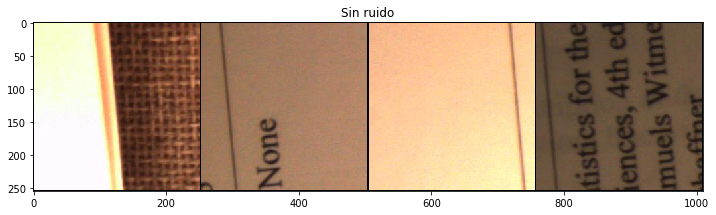

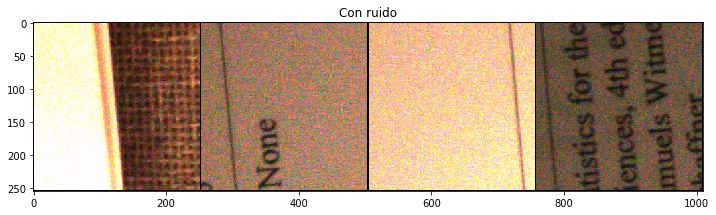

In [5]:
grid2 = torchvision.utils.make_grid(next(iter(doc_train_loader)), nrow=8)
plt.figure(figsize=(12, 12))
plt.imshow(grid2.permute(1, 2, 0))
plt.title('Sin ruido')
plt.show()
grid2 = torchvision.utils.make_grid(next(iter(doc_target_loader)), nrow=8)
plt.figure(figsize=(12, 12))
plt.imshow(grid2.permute(1, 2, 0))
plt.title('Con ruido')
plt.show()

## 2. Creación y configuración de modelo de aprendizaje

### Denoising autoencoder
Para resolver este problema se utilizará un denoising autoencoder, ya que es el modelo de aprendizaje profundo apropiado al poder representar la imagen aprendiendo las características útiles que quitarán el ruido y recuperarán la imagen

In [6]:
class NoiseRemoval(nn.Module):
  def __init__(self):
    super(NoiseRemoval, self).__init__()
    
    self.encoder = nn.Sequential(nn.Conv2d(3, 250, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2))
    
    self.decoder = nn.Sequential(nn.Conv2d(250, 250, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(250, 3, kernel_size=3, padding=1))
    
  def forward(self,x):
    return self.decoder(self.encoder(x))
  
net = NoiseRemoval()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### Estrategia de entrenamiento
Se emplearán un total de 1600 pares de sub-imágenes extraídas aleatoriamente de los 80 pares disponibles, y se entrenará durante 50 épocas.

In [ ]:
from datetime import timedelta
import time

start= time.time()

epochs = 50
for epoch in range(epochs):
  for x,y in zip(doc_train_loader, doc_target_loader):
    output = net(y)
    loss = criterion(output, x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))
  elapsed= time.time() - start
  print(str(timedelta(seconds=elapsed)))
  start= time.time()

## 3. Experimentación
A continuación se ejecutará el modelo con los datos de prueba, para mostrar la efectividad de la eliminación de ruido:

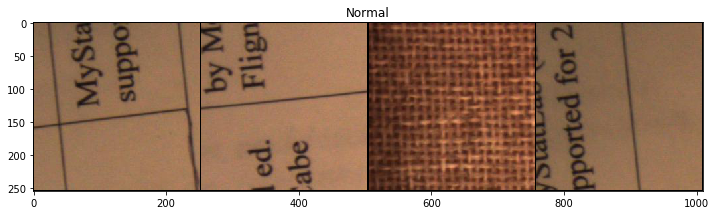

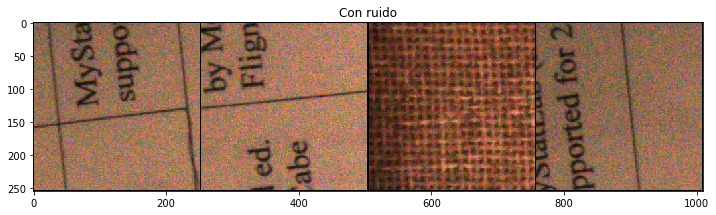

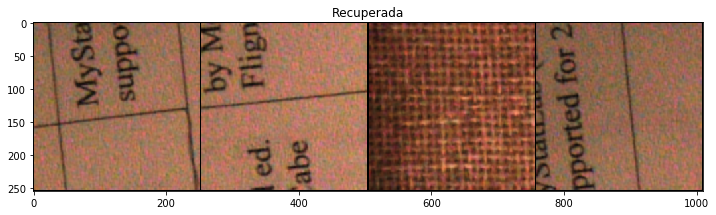

In [7]:
net = torch.load('/home/ubuntu/tac/modelo50.torch')

grid1 = torchvision.utils.make_grid(next(iter(doc_test_loader)), nrow=4)
plt.figure(figsize=(12, 12))
plt.imshow(grid1.permute(1, 2, 0))
plt.title('Normal')
plt.show()

grid2 = torchvision.utils.make_grid(next(iter(doc_test_target_loader)), nrow=4)
plt.figure(figsize=(12, 12))
plt.imshow(grid2.permute(1, 2, 0))
plt.title('Con ruido')
plt.show()

data = next(iter(doc_test_target_loader))
with torch.no_grad():
  out = net(data)

grid3 = torchvision.utils.make_grid(out.cpu(), nrow=4)
plt.figure(figsize=(12, 12))
plt.imshow(grid3.permute(1, 2, 0))
plt.title('Recuperada')
plt.show()

Esta función nos permitirá calcular la variación total entre los pixeles adyacentes de un batch de imágenes, y así tener un valor que represente el nivel de ruido del batch:

In [10]:
def total_variation_dddd(images, batch=True):
    # Mediante slicing, las imagenes son desplazadas un píxel en altura y anchura,
    # con el fin de calcular la diferencia entre píxeles adyacentes
    pixel_dif1 = images[:, 1:, :, :] - images[:, :-1, :, :]
    pixel_dif2 = images[:, :, 1:, :] - images[:, :, :-1, :]
    
    # Se calcula la variación total tomando el valor absoluto de las diferencias y sumando en los ejes apropiados
    tot_var = (math_ops.reduce_sum(math_ops.abs(pixel_dif1), axis=[1, 2, 3]) +
               math_ops.reduce_sum(math_ops.abs(pixel_dif2), axis=[1, 2, 3]))
    return tot_var

In [12]:
def get_deviation(noise_removed_arr, reference_arr):
    sum = 0
    noise_removed_arr = np.array(noise_removed_arr)
    reference_arr = np.array(reference_arr)

    N = len(noise_removed_arr)
    for i in range(N):
        sum += (noise_removed_arr[i] - reference_arr[i])**2

    return math.sqrt((sum/len(noise_removed_arr)))

In [ ]:
iter_test = iter(doc_test_loader)
iter_test_comp = iter(doc_test_target_loader)
doc_test_target_loader

dev_result_comp = []
dev_test_comp = []

for i in range(len(doc_test_target_loader)):
    test_batch = next(iter_test)
    test_comp_batch = next(iter_test_comp)
    with torch.no_grad():
        result_batch = net(test_batch)
    
    # print(get_deviation(total_variation_dddd(result_batch, True),  total_variation_dddd(test_comp_batch, True)))
    # print(get_deviation(total_variation_dddd(test_batch, True),  total_variation_dddd(test_comp_batch, True)))

    dev_result_comp.append(get_deviation(total_variation_dddd(result_batch, True),  total_variation_dddd(test_comp_batch, True)))
    dev_test_comp.append(get_deviation(total_variation_dddd(test_batch, True),  total_variation_dddd(test_comp_batch, True)))

print("Variacion total de los casos de test base = {}" .format(statistics.mean(dev_test_comp)))
print("Variacion total de los casos de test despues de aplicado el removedor de ruido = {}" .format(statistics.mean(dev_result_comp)))

## 4. Discusión de Resultados y Conclusiones